In [2]:
from numpy.polynomial import Legendre, Polynomial
from scipy.integrate import quad
from scipy.optimize import approx_fprime
from matplotlib.colors import TwoSlopeNorm
from scipy.integrate import solve_ivp
from scipy.linalg import expm

from unhippo.lds import hippo_matrices

In [3]:
def leg_basis(n: int):
    return Legendre([0] * n + [1])

def inner_prod(a: Legendre, b: Legendre):
    return quad(lambda x: a(x) * b(x), -1, 1)[0]

def proj_leg(f, n: int):
    coefs = [inner_prod(f, leg_basis(i)) for i in range(n)]
    coefs = np.array(coefs)

    return (2 * np.arange(n) + 1) / 2 * coefs

In [4]:
def f(x):
    return 2 * x**2 - 3 * x - 0.5
    #return -x**2 + 1.25 * x + 0.333
    #return x - 0.5
    return x**4 - 0.5

def coef_t(t):
    phi = lambda x: (x + 1) / 2 * t
    g = lambda x: f(phi(x))

    return proj_leg(g, n=5)

In [5]:
t = np.linspace(1.0, 10.0, 40)
c = np.stack([coef_t(t_) for t_ in t])
dcdt = np.stack([approx_fprime(t_, coef_t)[:, 0] for t_ in t])

In [6]:
A, res, rank, singular_values = np.linalg.lstsq(c, dcdt, rcond=None)

A

array([[ 3.00000022e+00,  2.99999971e+00, -4.68703869e-08,
        -1.80284707e-08, -4.81572249e-08],
       [-3.88888915e+00, -4.33333298e+00, -4.44444376e-01,
         2.37734706e-08,  5.26663595e-08],
       [ 5.66666700e+00,  6.99999956e+00,  1.33333324e+00,
        -2.91401017e-08, -6.11244382e-08],
       [ 1.06812376e-13,  1.23602531e-13,  1.67901687e-14,
        -5.95696655e-22, -1.34027663e-21],
       [ 8.95989696e-14,  1.03581172e-13,  1.39822138e-14,
        -5.00281051e-22, -1.12658815e-21]])

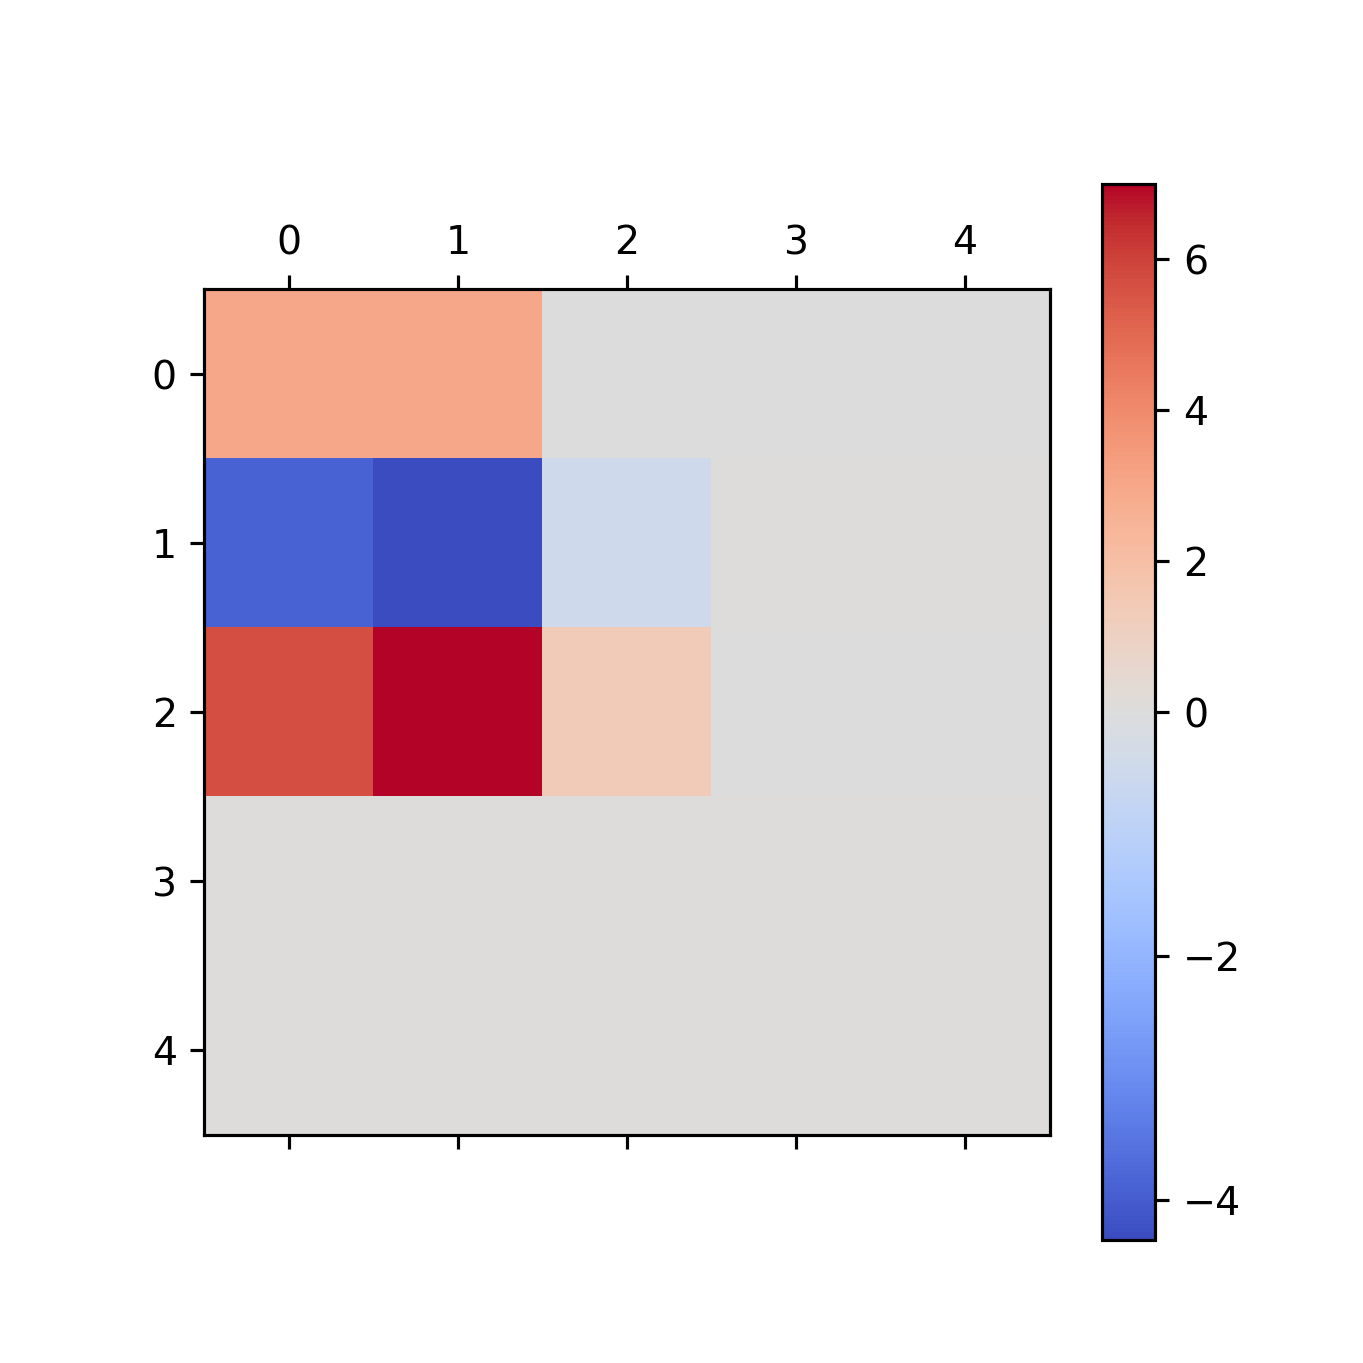

In [7]:
pp.matshow(A, norm=TwoSlopeNorm(0), cmap="coolwarm")
pp.colorbar()

Text(0.5, 1.0, 'c')

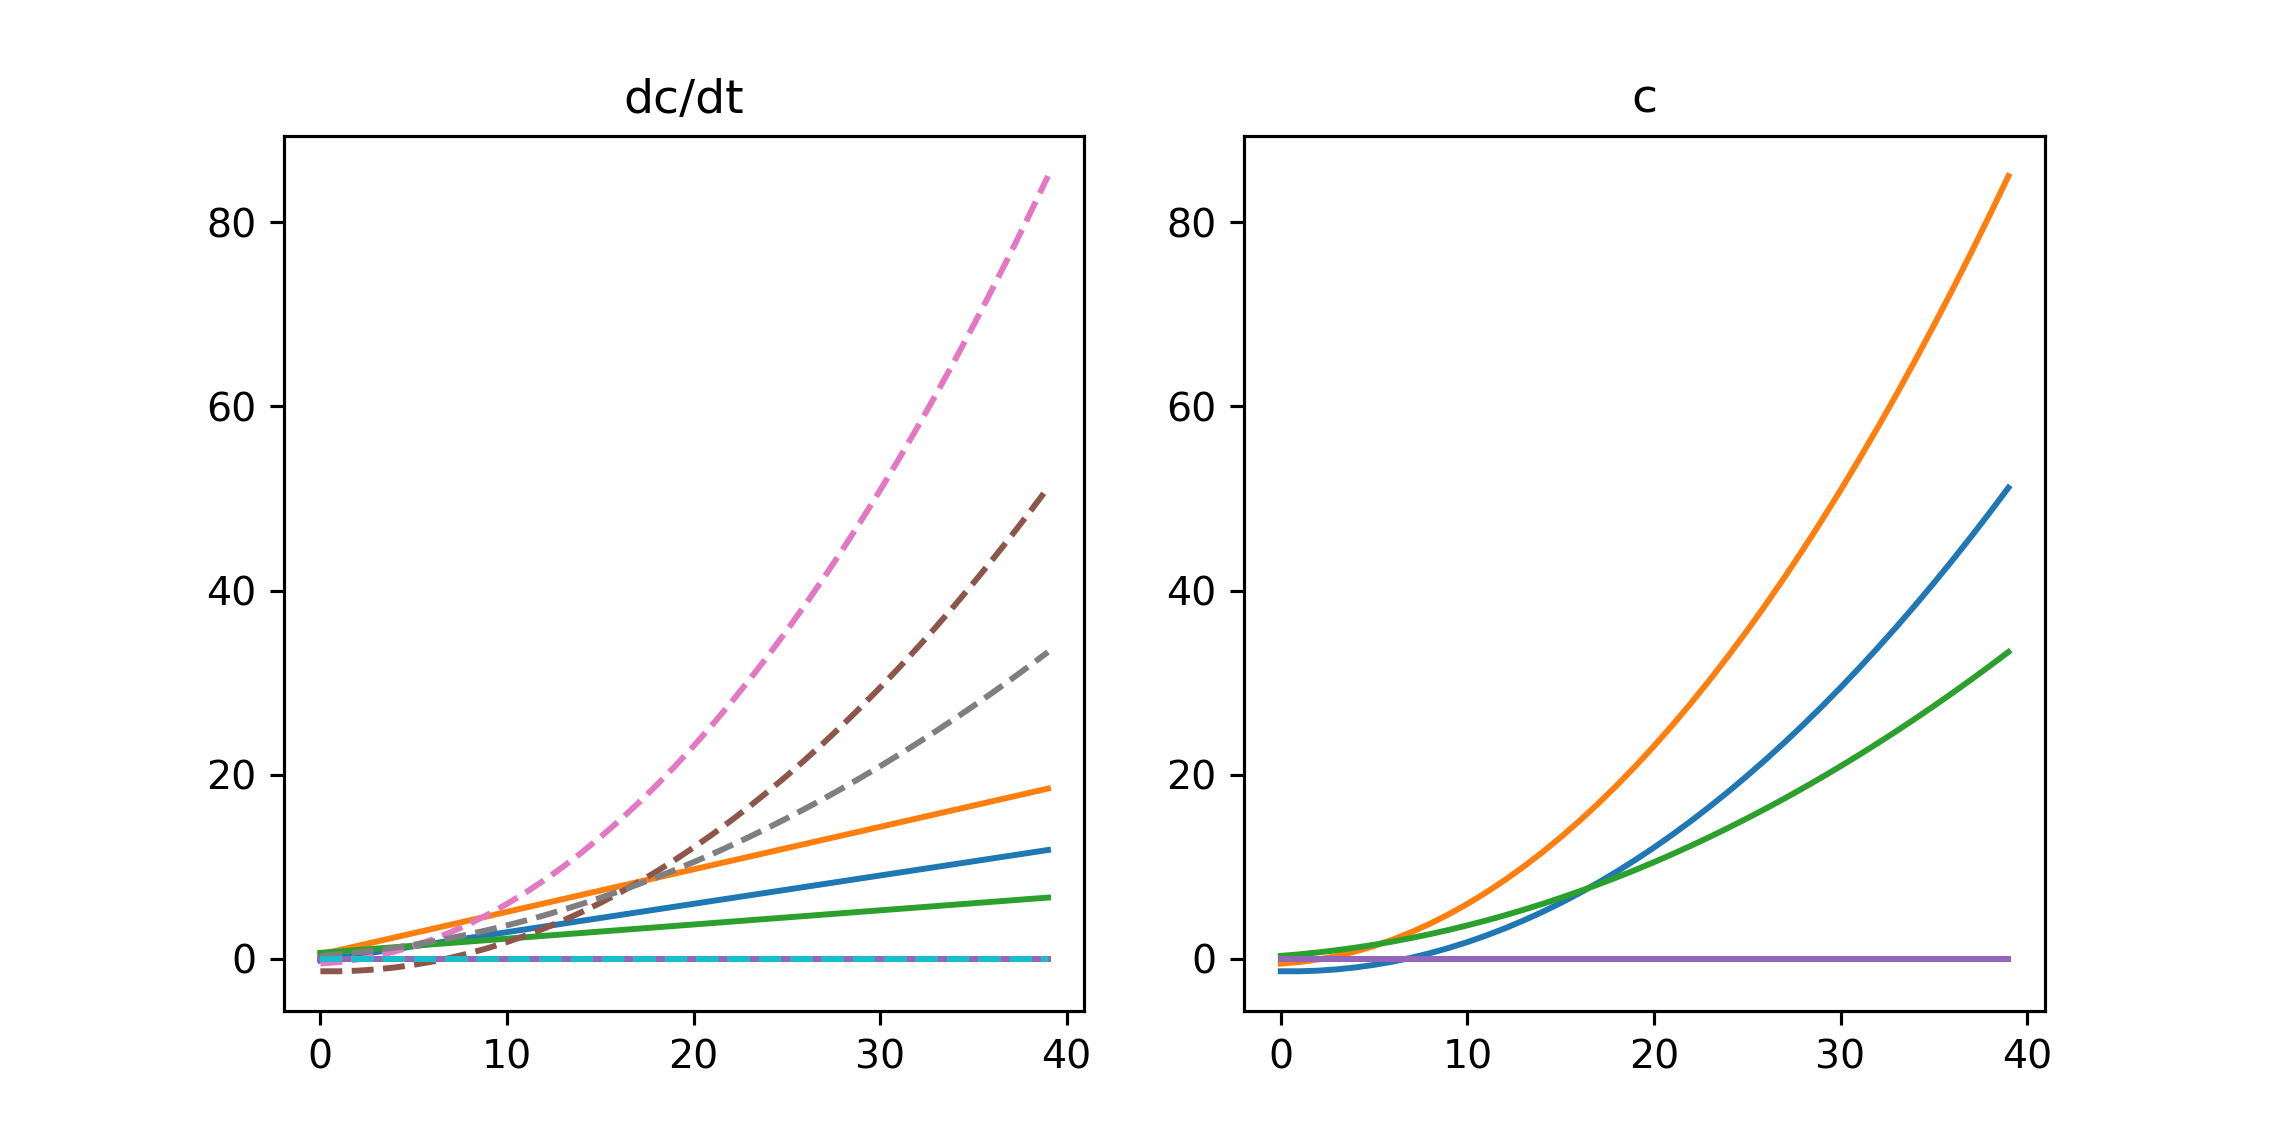

In [8]:
fig = pp.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.plot(dcdt)
ax.plot(c, ls="--")
ax.set_title("dc/dt")
ax = fig.add_subplot(122)
ax.plot(c)
ax.set_title("c")

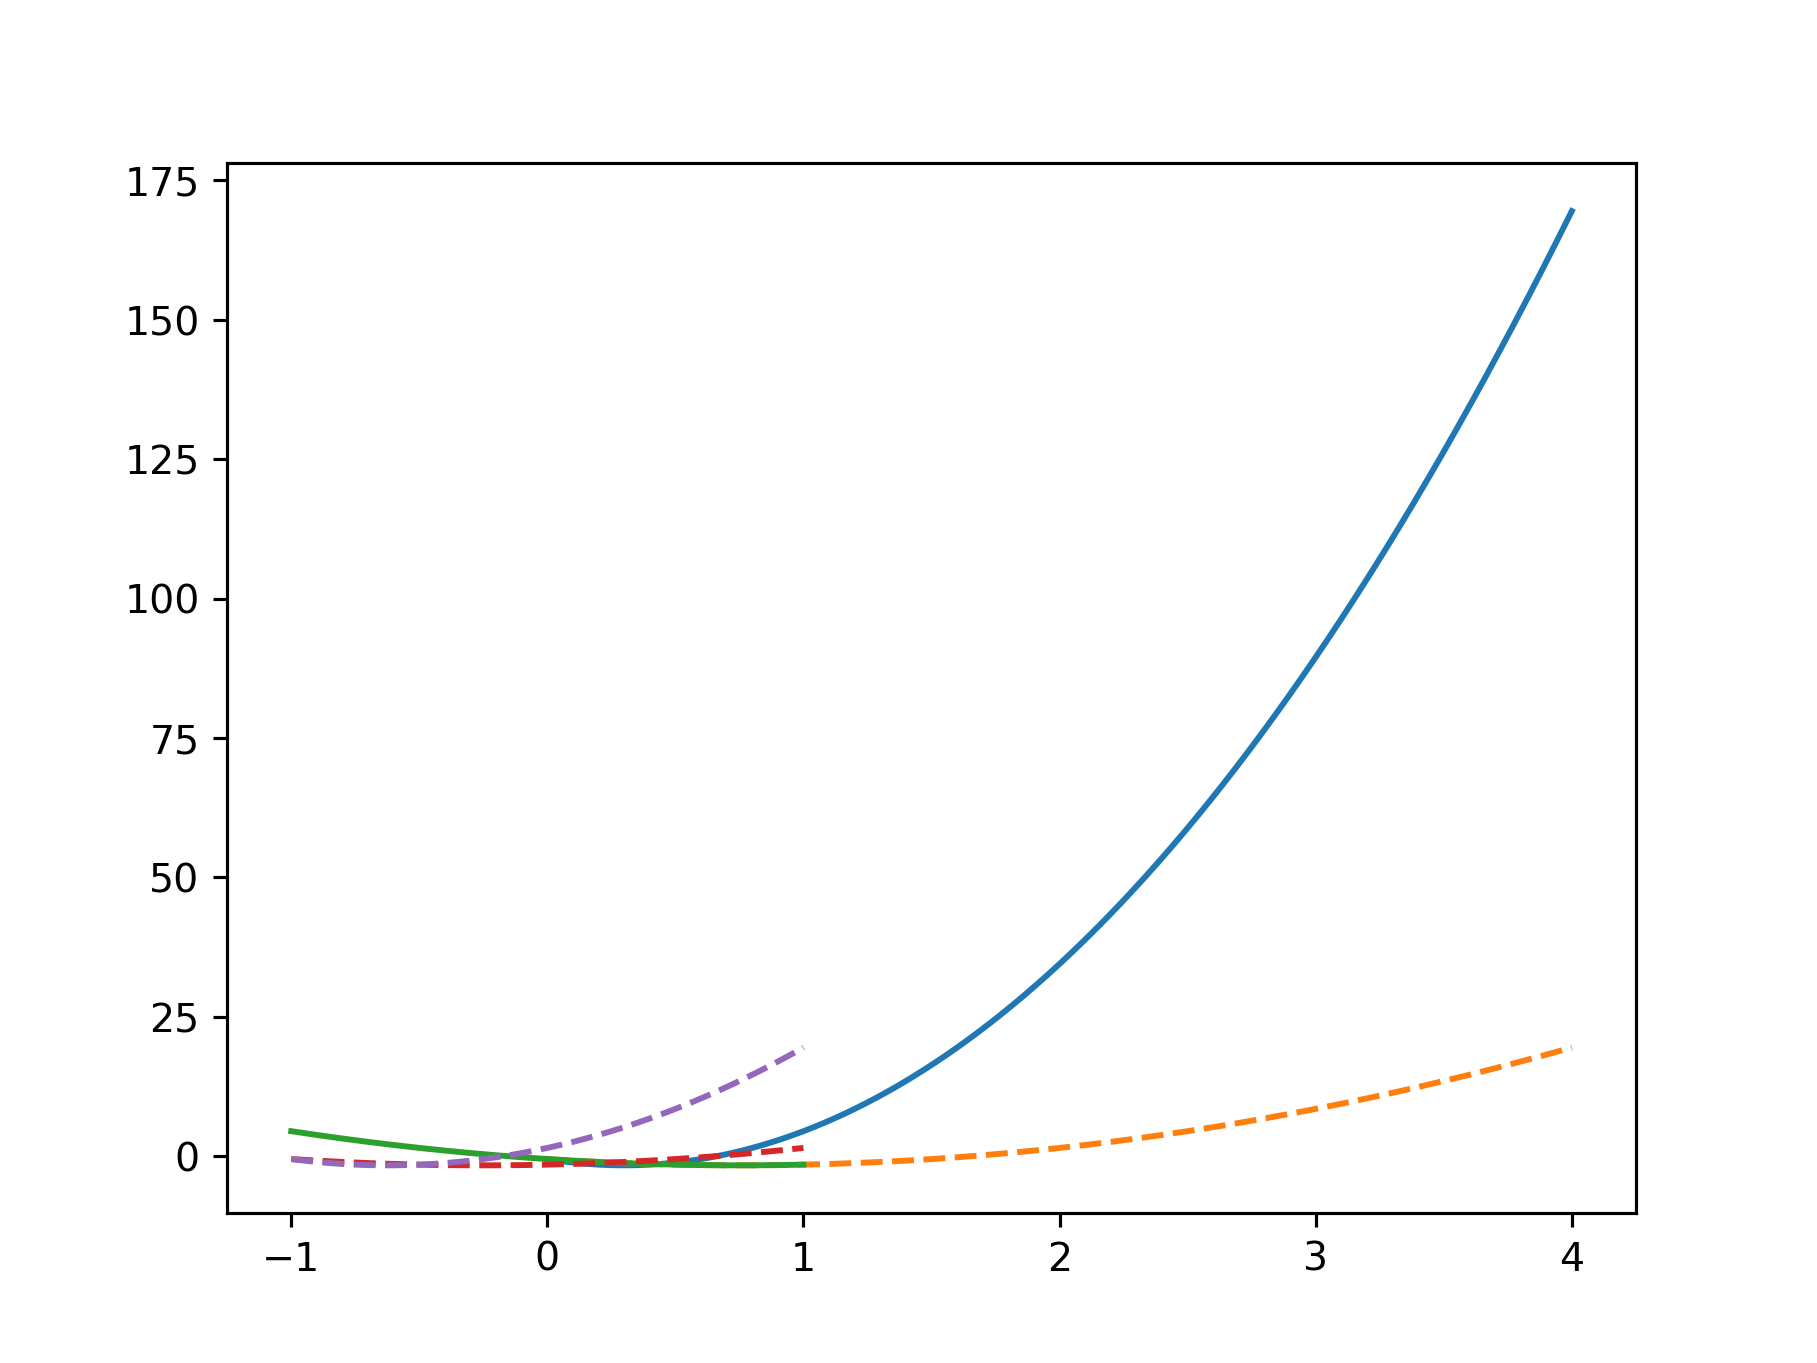

In [9]:
x = np.linspace(0.0, 4.0, 1000)
pp.plot(x, Legendre(c[-1], domain=(0, 4))(x))
pp.plot(x, f(x), ls="--")

poly = Legendre(proj_leg(f, 3))
poly2 = Legendre(coef_t(2.0))
poly4 = Legendre(coef_t(4.0))

x = np.linspace(-1, 1, 1000)
pp.plot(x, f(x))
pp.plot(x, poly2(x), ls="--")
pp.plot(x, poly4(x), ls="--")

Text(0.5, 1.0, 'HiPPO matrix squeezes data into $[-1, 1]$ and continues with $0$')

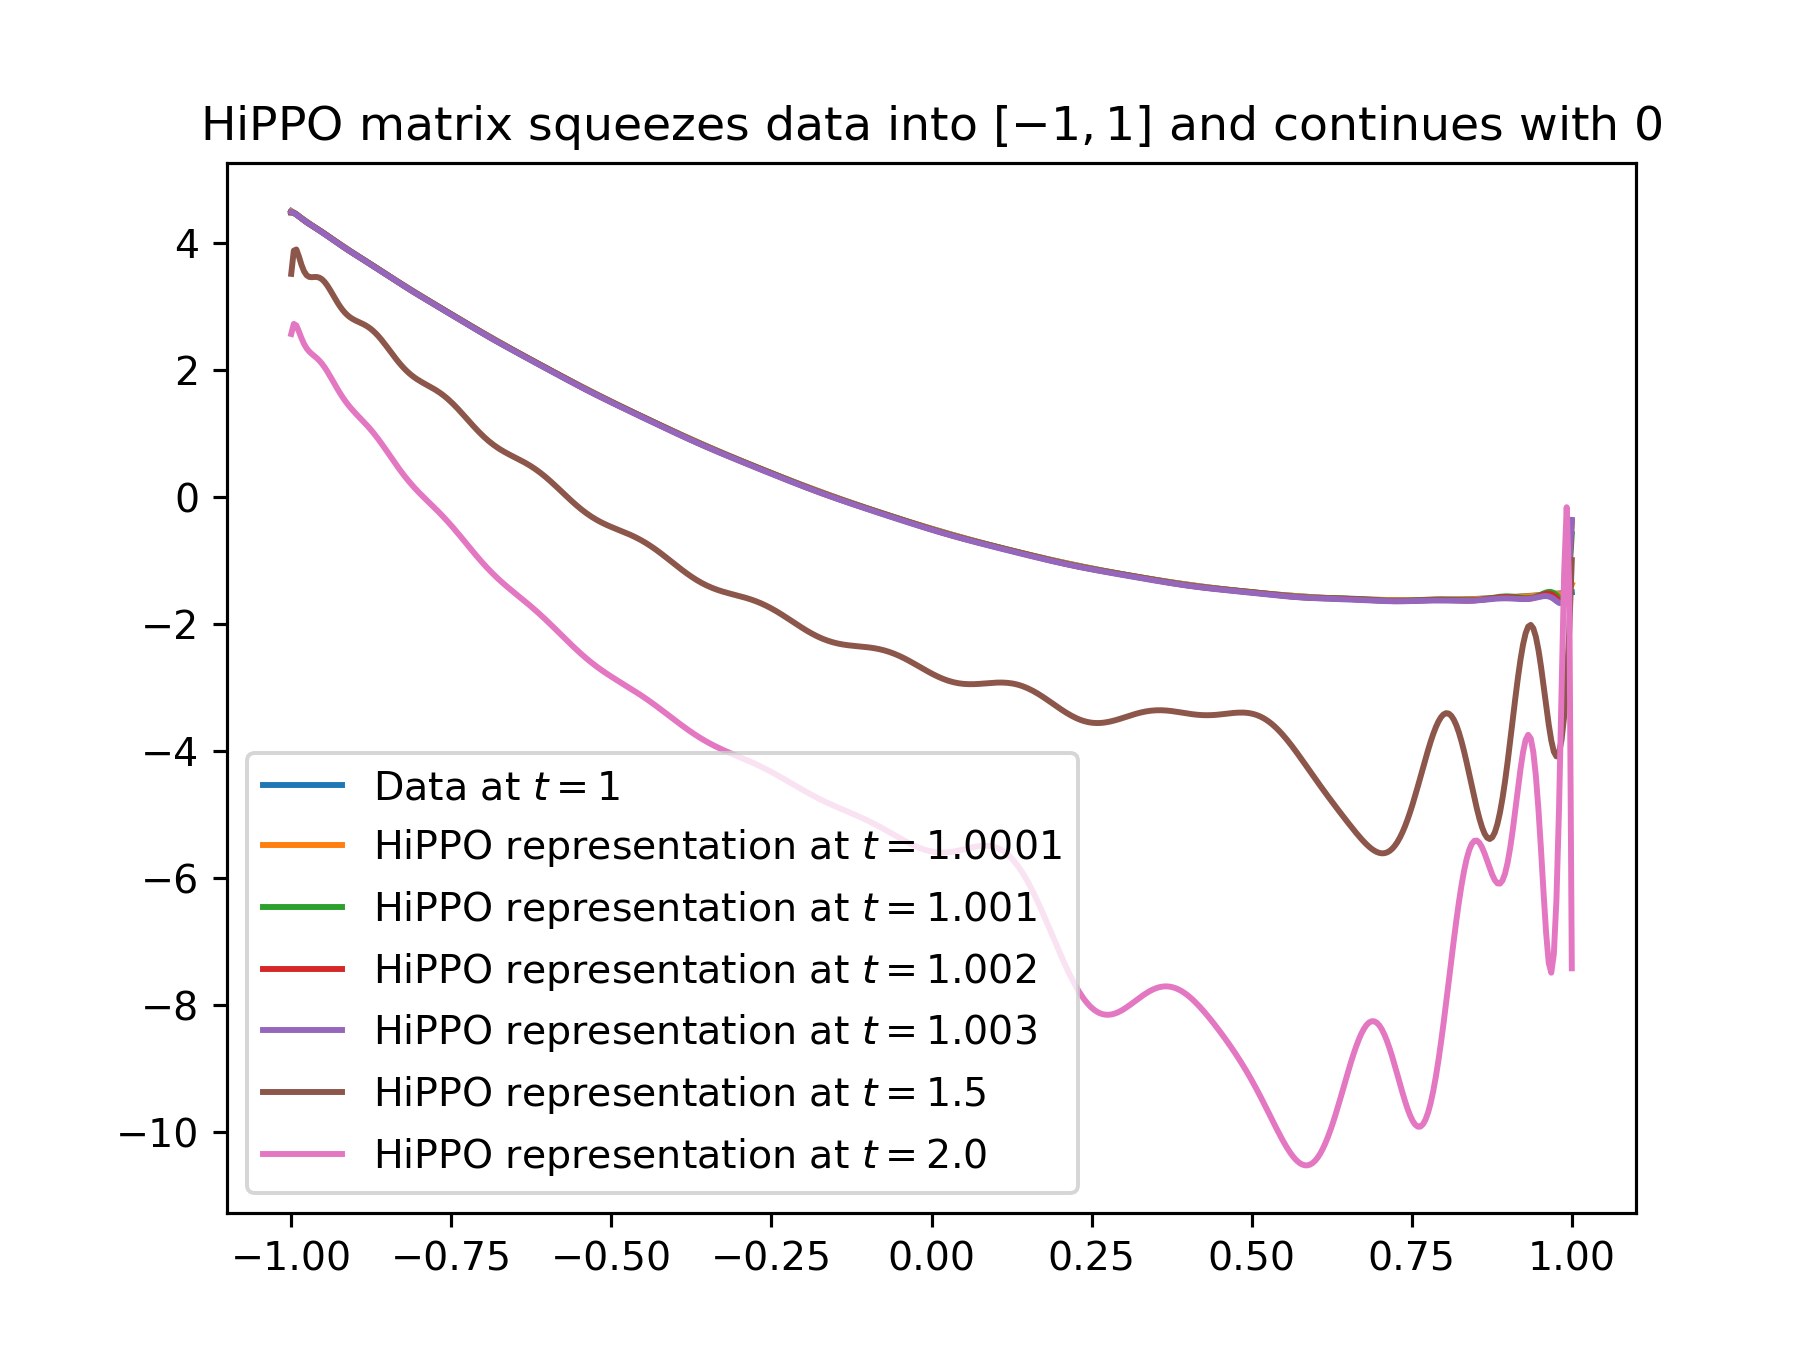

In [10]:
n = 32
A, B = hippo_matrices(n)
def f(x):
    return 2 * x**2 - 3 * x - 0.5
c = proj_leg(f, n)

x = np.linspace(-1, 1, 500)
poly_c = Legendre(c)
pp.plot(x, poly_c(x), label=r"Data at $t=1$")

for dt in [1e-4, 1e-3, 2e-3, 3e-3, 0.5, 1.0]:
    t0 = 1.0
    c_later = solve_ivp(lambda t, c_: -A/t @ c_ - np.abs((B * B * c_).sum() / t), (t0, t0 + dt), c / B).y[:, -1] * B.numpy()
    poly_later = Legendre(c_later)
    pp.plot(x, poly_later(x), label=rf"HiPPO representation at $t={t0+dt}$")
pp.legend()
pp.title(r"HiPPO matrix squeezes data into $[-1, 1]$ and continues with $0$")

In [11]:
def my_hippo_matrix(n: int) -> np.ndarray:
    p = Polynomial([1, 1]).convert(kind=Legendre)
    A = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            coef = 1 # np.sqrt((2 * i + 1) * (2 * j + 1))
            coef = (2 * i + 1) / 2
            A[i, j] = coef * inner_prod(p * leg_basis(j).deriv(), leg_basis(i))
    return A

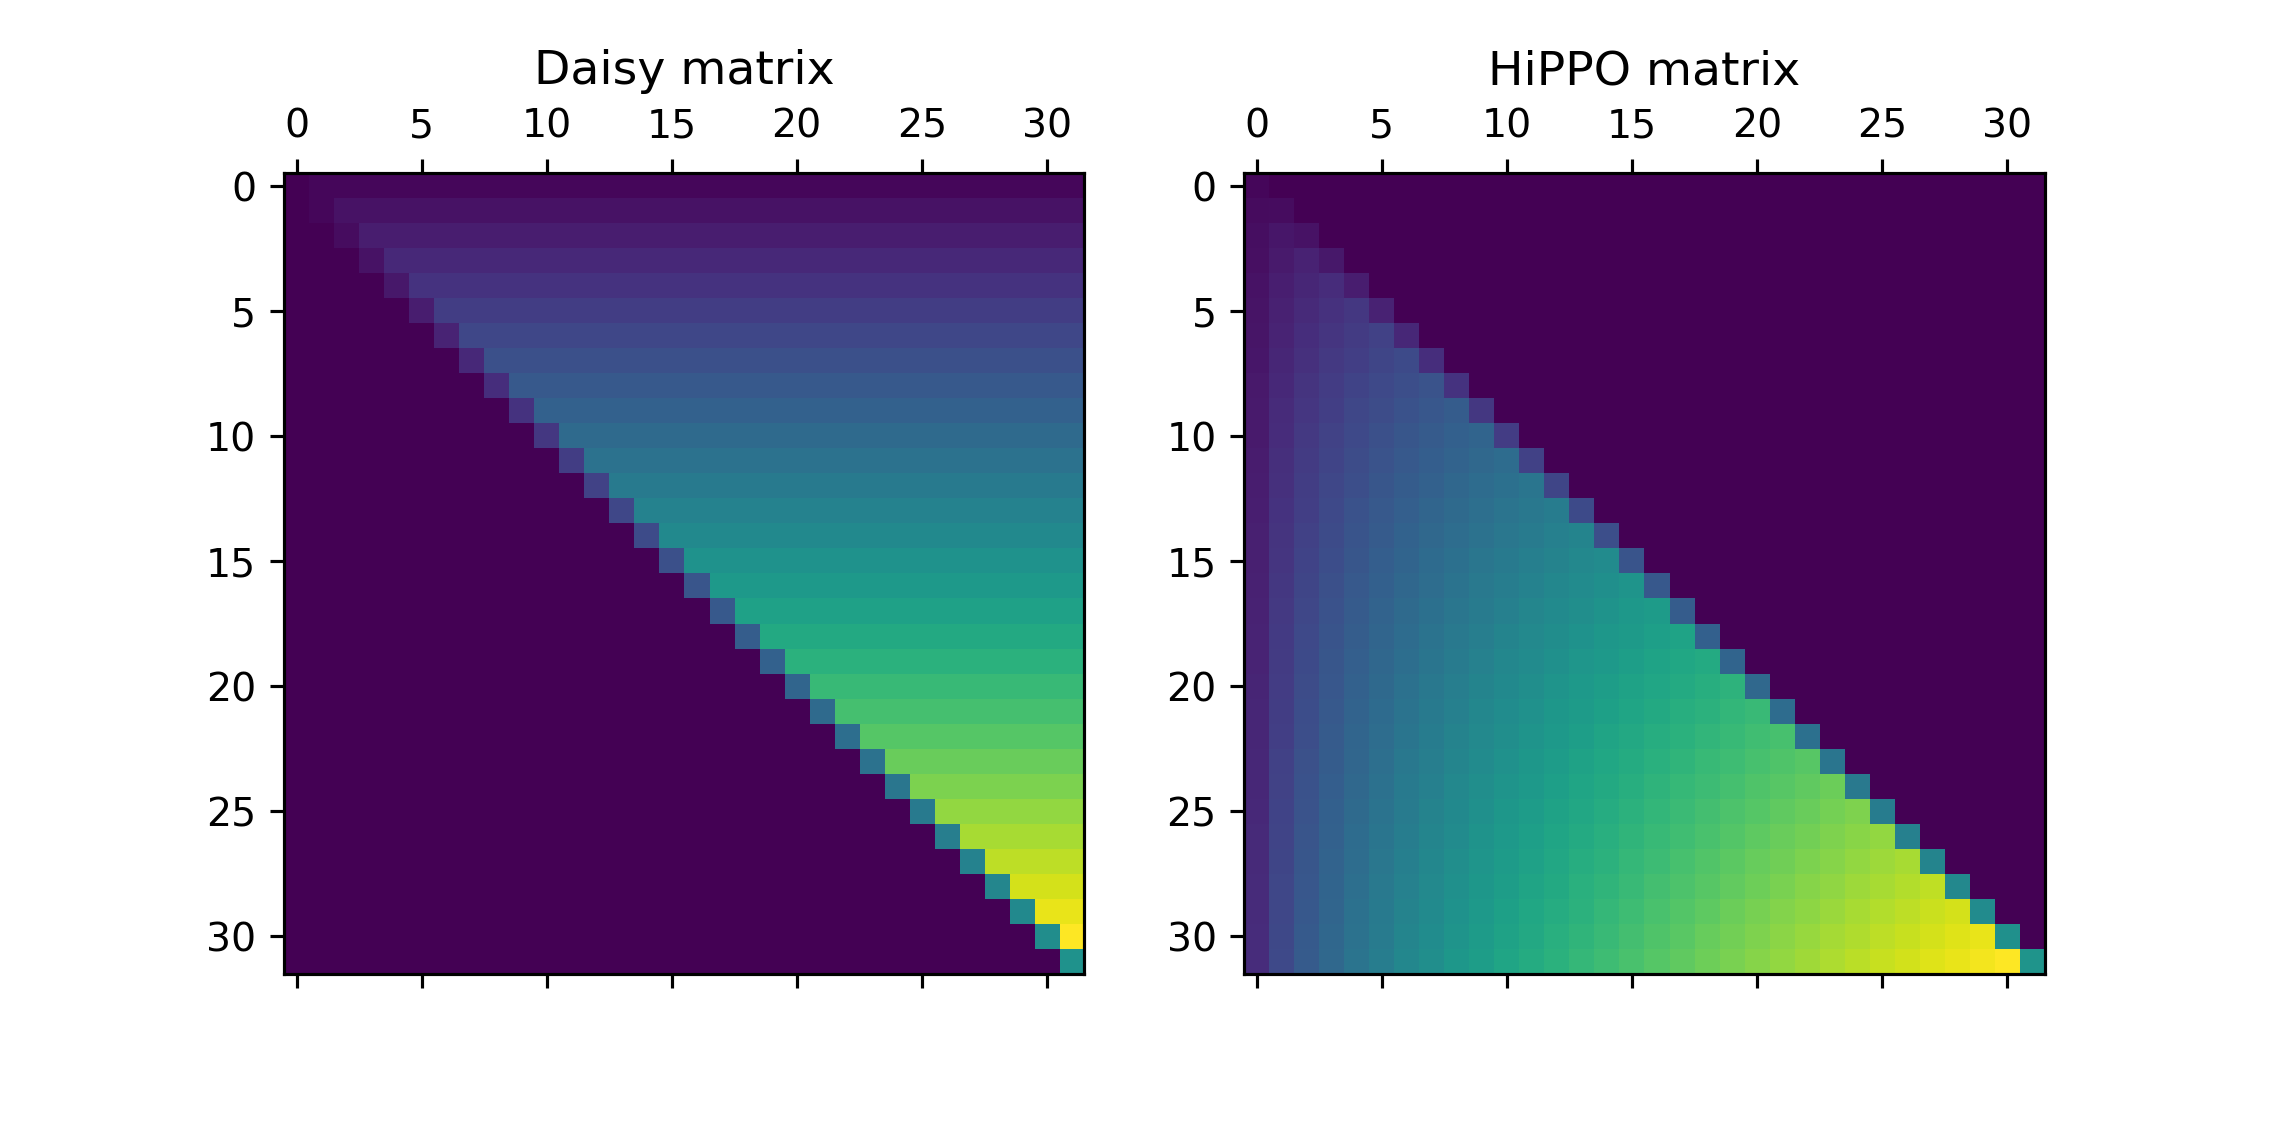

In [12]:
A_hippo, _ = hippo_matrices(n)
A = my_hippo_matrix(n)
fig = pp.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.set_title("Daisy matrix")
ax.matshow(A)
ax = fig.add_subplot(122)
ax.set_title("HiPPO matrix")
ax.matshow(A_hippo)

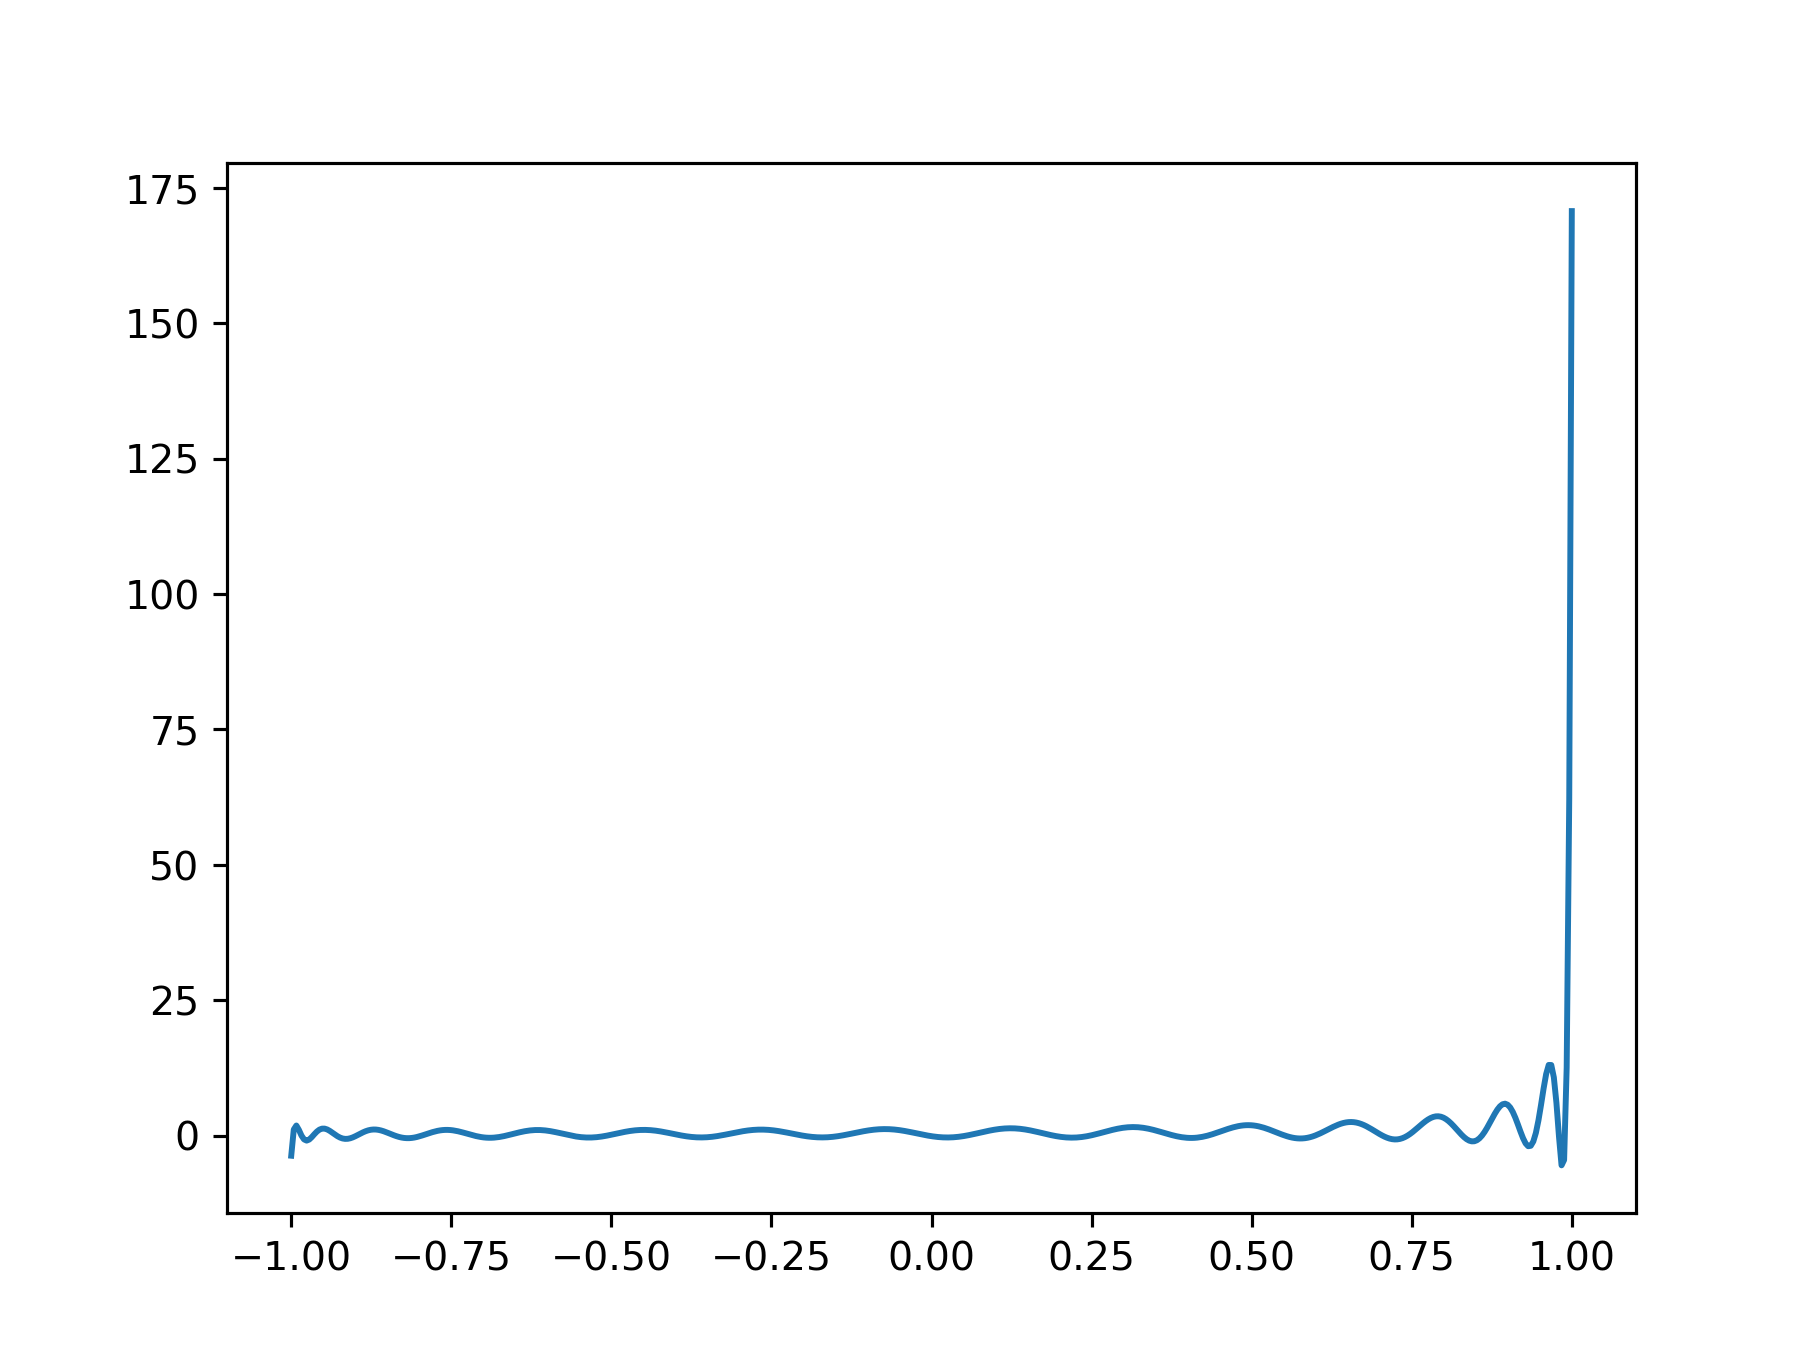

In [14]:
_, B_hippo = hippo_matrices(n)

poly_update = Legendre(B_hippo.numpy())
pp.plot(x, poly_update(x))

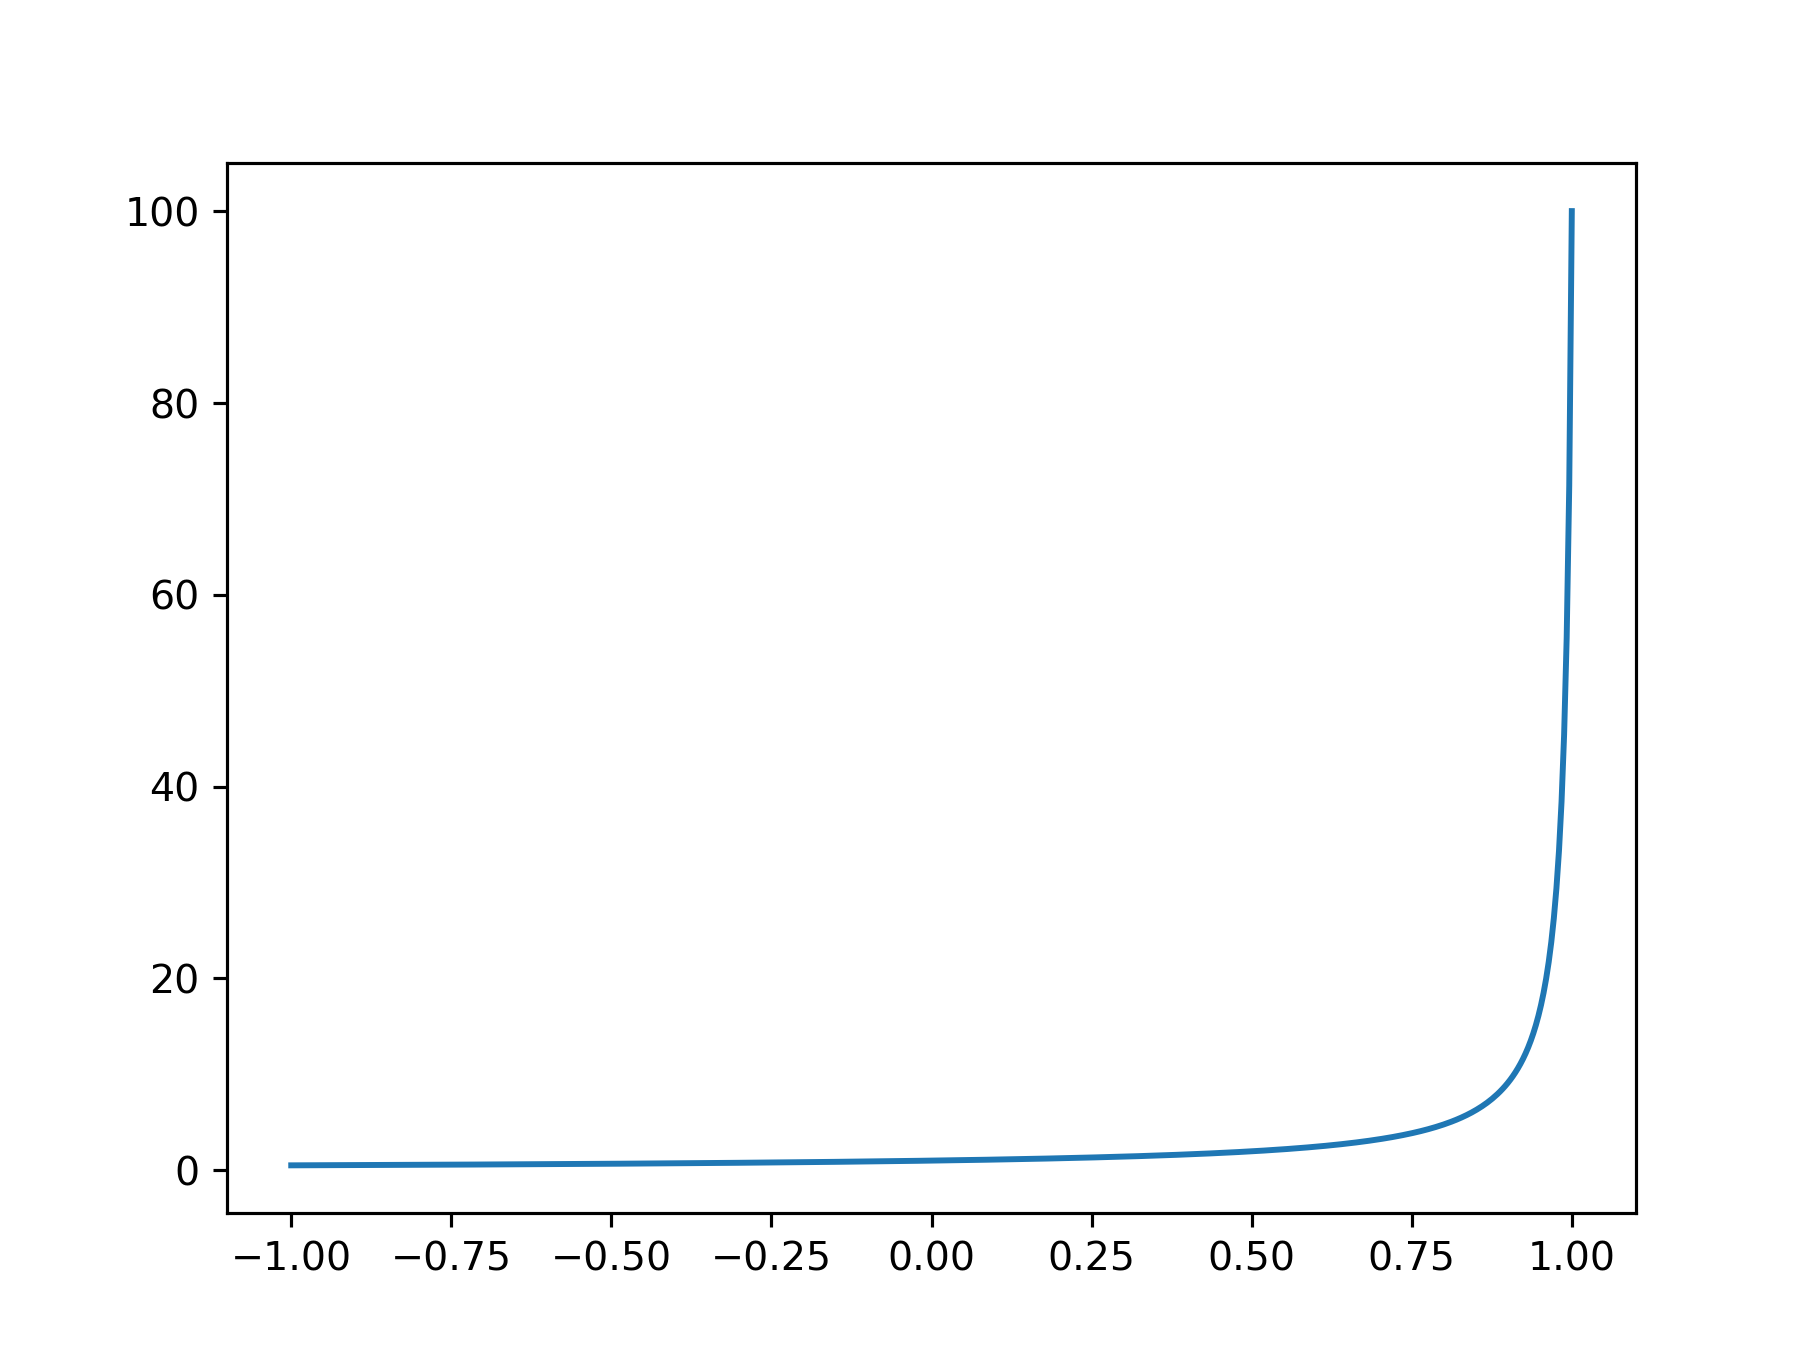

In [15]:
pp.plot(x, 1 / (-x + 1 + 1e-2))

In [16]:
poly_smooth_update = Legendre.fit(x, 1 / (-x + 1 + 1e-2), n)

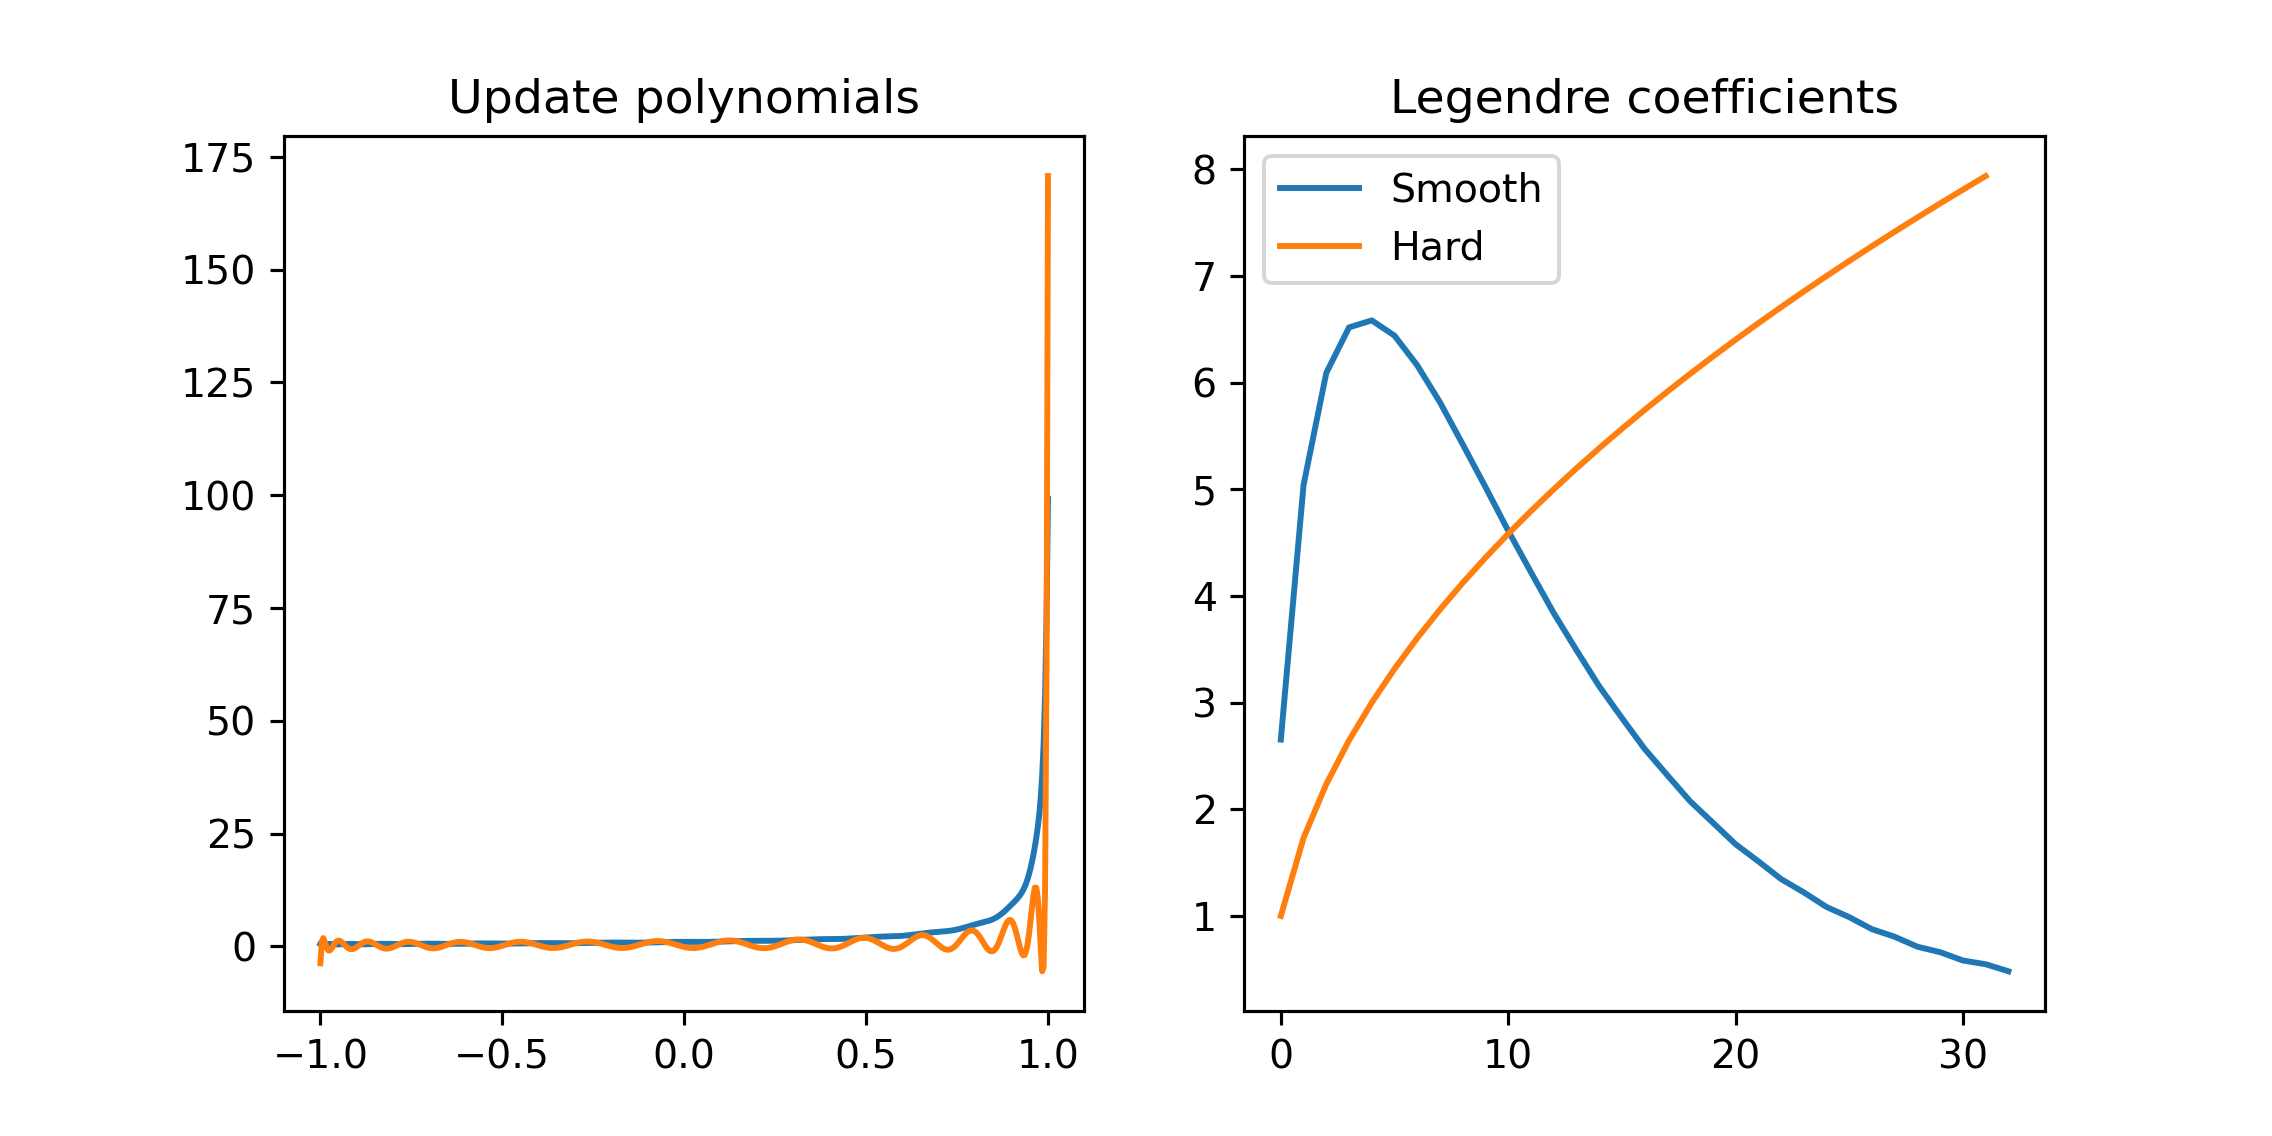

In [17]:
fig = pp.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.set_title("Update polynomials")
ax.plot(x, poly_smooth_update(x), label="Smooth")
ax.plot(x, poly_update(x), label="Hard")
ax = fig.add_subplot(122)
ax.set_title("Legendre coefficients")
ax.plot(poly_smooth_update.coef, label="Smooth")
ax.plot(poly_update.coef, label="Hard")
ax.legend()

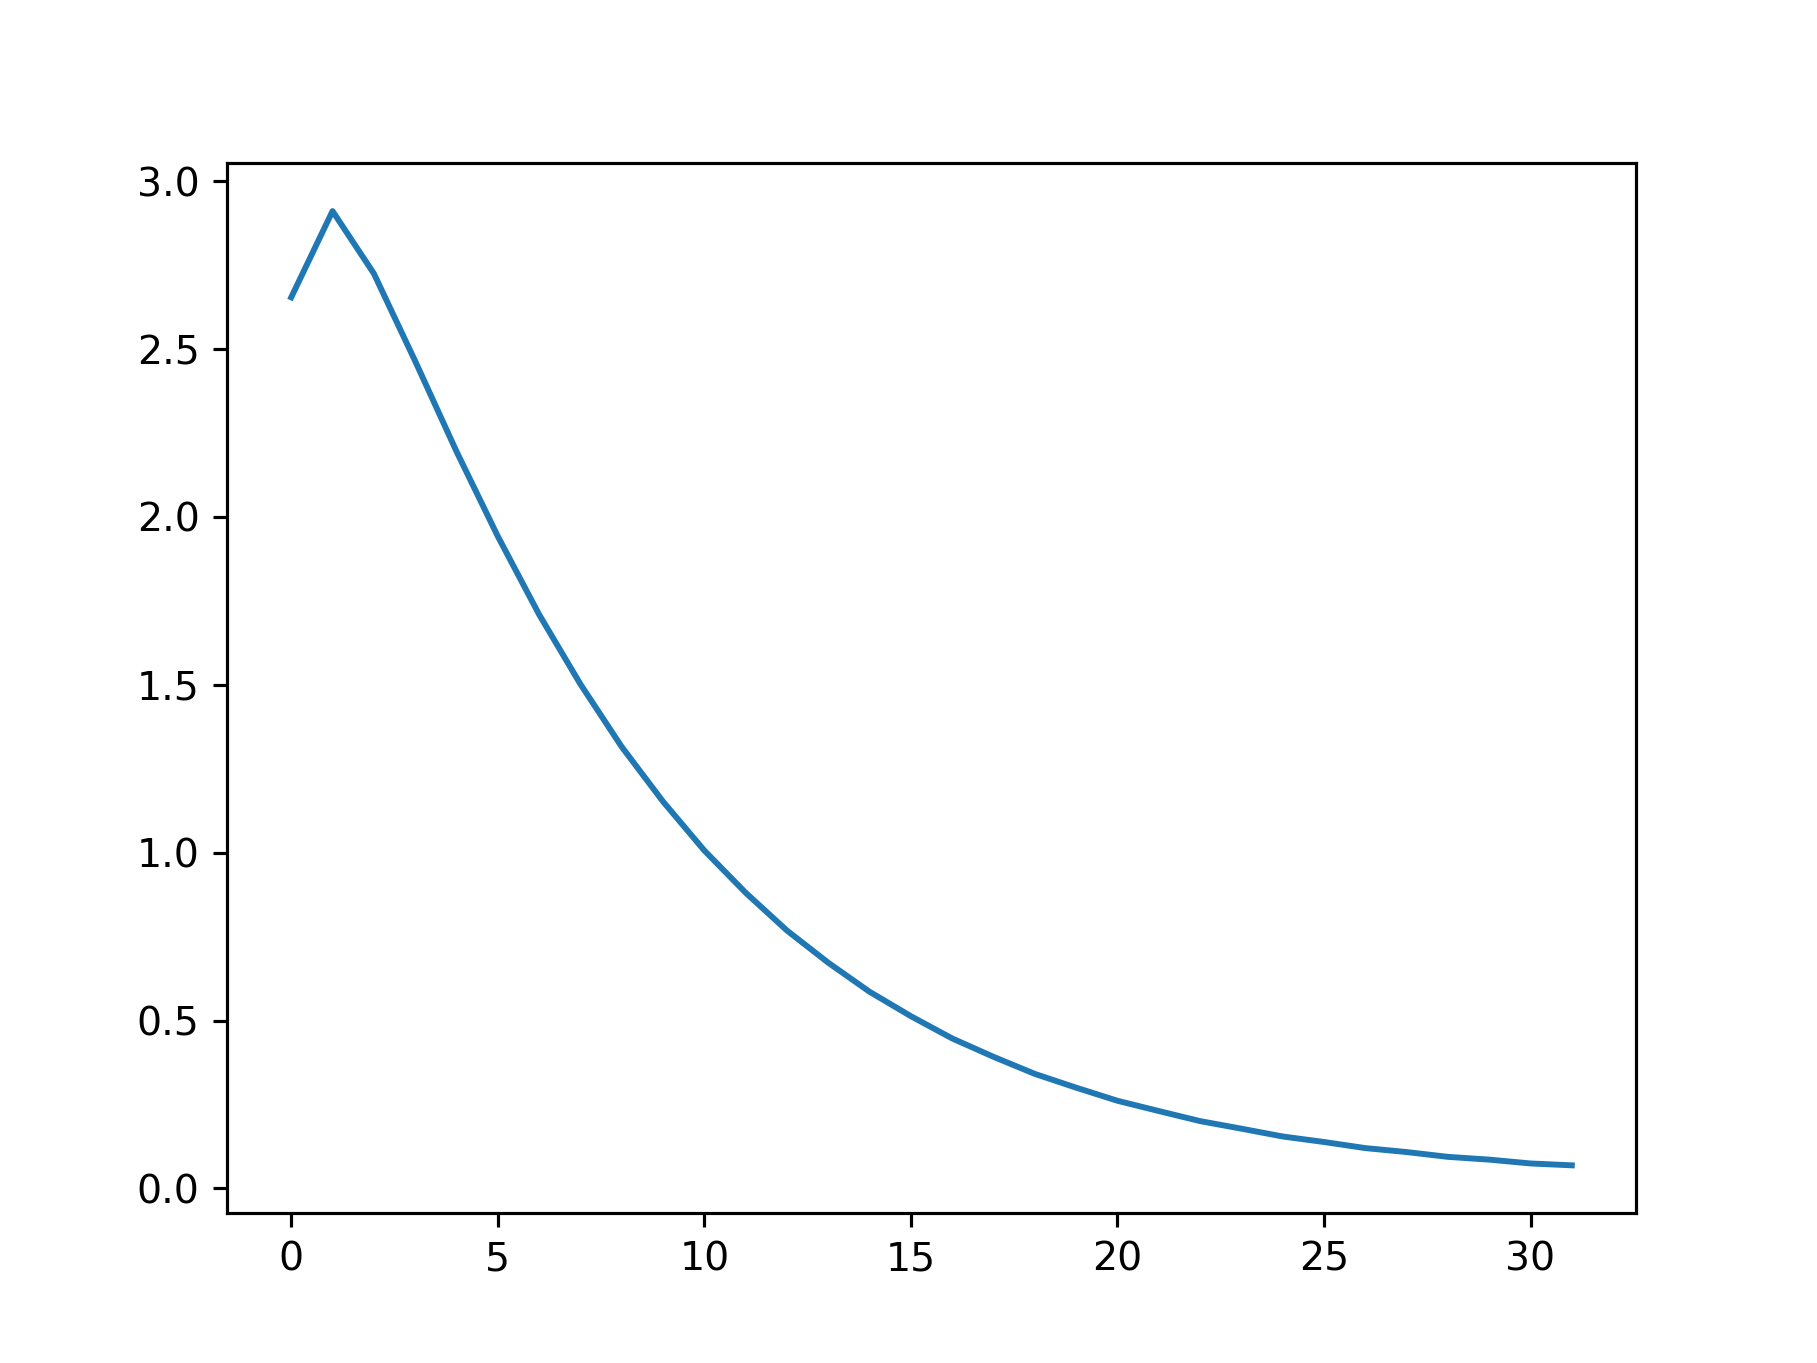

In [18]:
pp.plot(poly_smooth_update.coef[:-1] / poly_update.coef)

Text(0.5, 1.0, 'Daisy matrix squeezes data into $[-1, 1]$ and extrapolates smoothly')

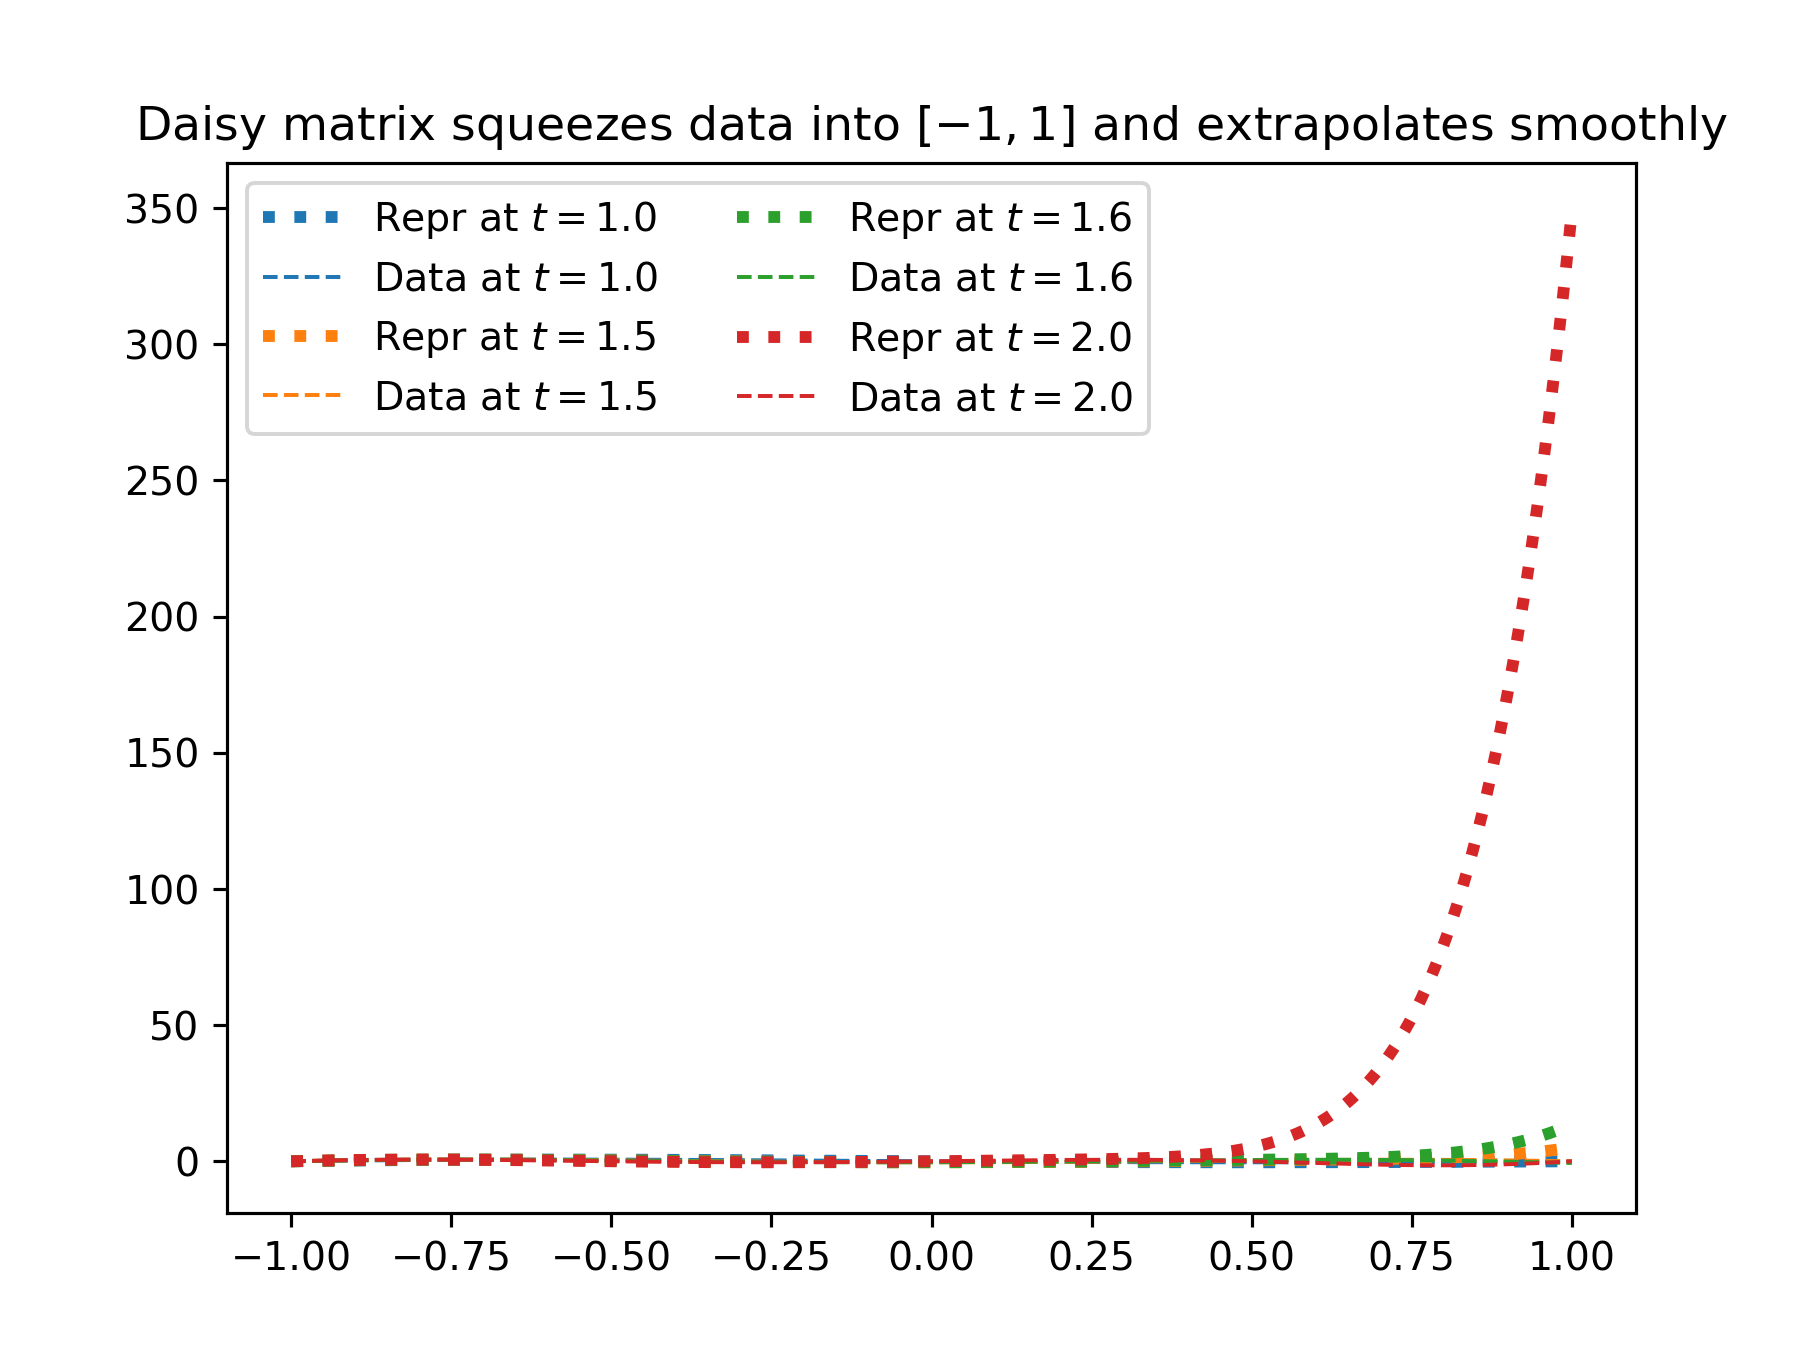

In [45]:
n = 10
A = my_hippo_matrix(n)
f = Polynomial([-0.5, -3, 2])
def f(t):
    t = 2 * t
    return np.sin(np.pi * t) * np.exp(-np.sin(t))

def A_t(t):
    A = np.zeros(n)
    df = f.deriv()
    for i in range(n):
        dphidt = Polynomial([1, 1]) / 2
        A[i] = (2 * i + 1) / 2 * inner_prod(lambda x: dphidt(x) * df(t * (x + 1) / 2), leg_basis(i))
    return A

def c_t(t):
    return proj_leg(lambda x: f(t * (x + 1) / 2), n)

c = proj_leg(lambda x: f((x + 1) / 2), n)

x = np.linspace(-1, 1, 500)
poly_c = Legendre(c)

for dt in [0.0, 0.5, 0.6, 1.0]:
    t0 = 1.0
    t = t0 + dt
    #c_later = solve_ivp(lambda t, c_: 1/t * A @ c_, (t0, t0 + dt), c).y[:, -1]

    def step(t, Phi):
            return ((A / t) @ Phi.reshape((n, n))).reshape(-1)

    sol = solve_ivp(step, (t0, t0 + dt), np.identity(n).reshape(-1))
    Phi = sol.y[:, -1].reshape((n, n))
    c_later = Phi @ c

    #c_later = solve_ivp(lambda t, c_: A_t(t), (t0, t0 + dt), c).y[:, -1]
    poly_later = Legendre(c_later)
    line, = pp.plot(x, poly_later(x), label=rf"Repr at $t={t}$", ls=":", lw=3)
    pp.plot(x, f(t * (x + 1) / 2), label=rf"Data at $t={t}$", ls="--", lw=1, c=line.get_color())

pp.legend(ncols=2)
pp.title(r"Daisy matrix squeezes data into $[-1, 1]$ and extrapolates smoothly")

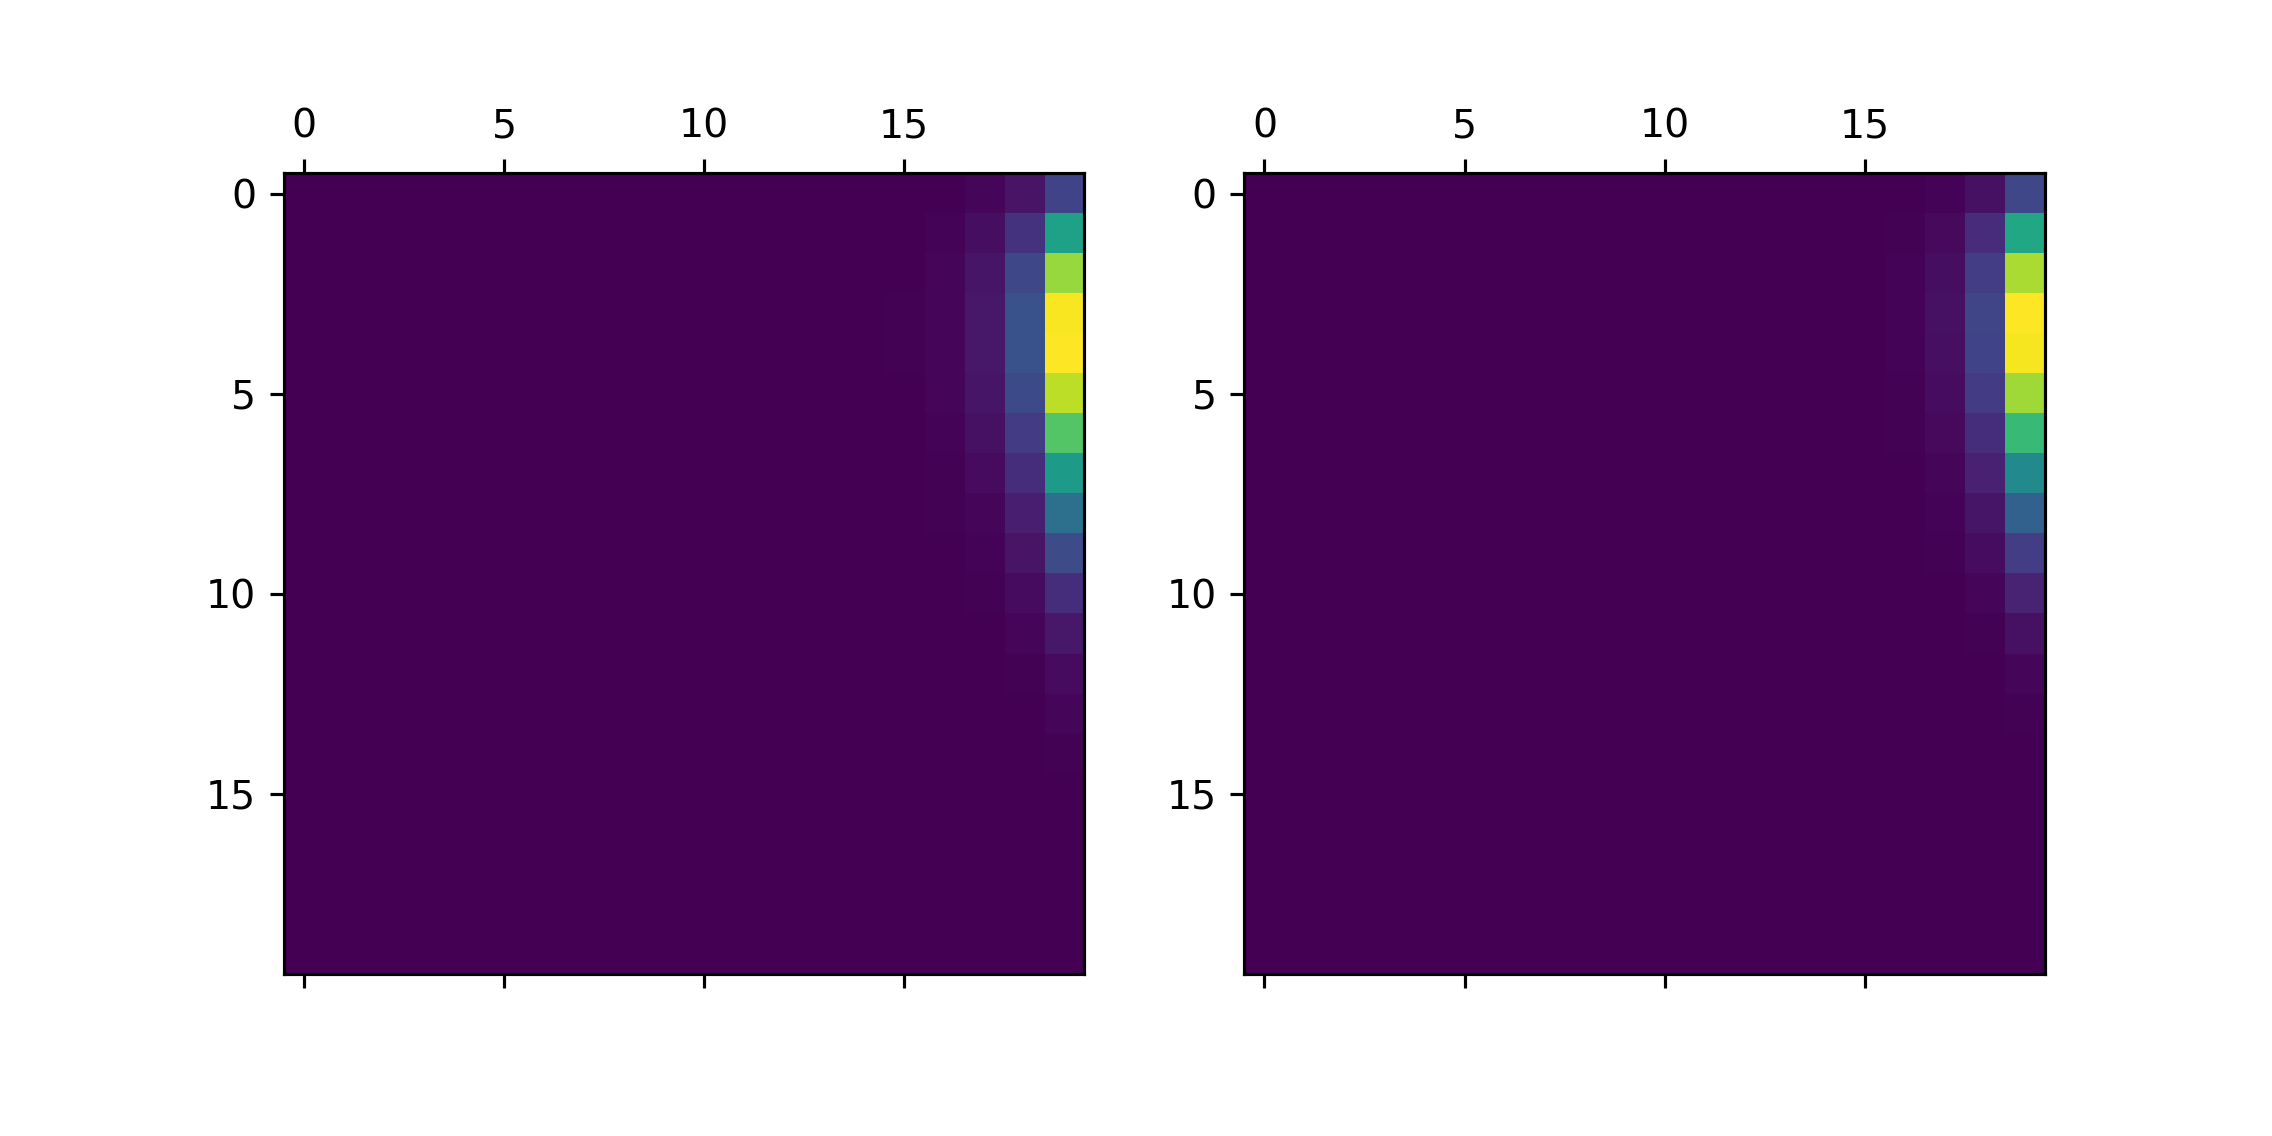

In [37]:
fig = pp.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.matshow(Phi)
ax = fig.add_subplot(122)
ax.matshow(expm(dt * A))

Text(0.5, 1.0, 'Regularizing first 8 derivs at $x=1$ makes constant roll-out')

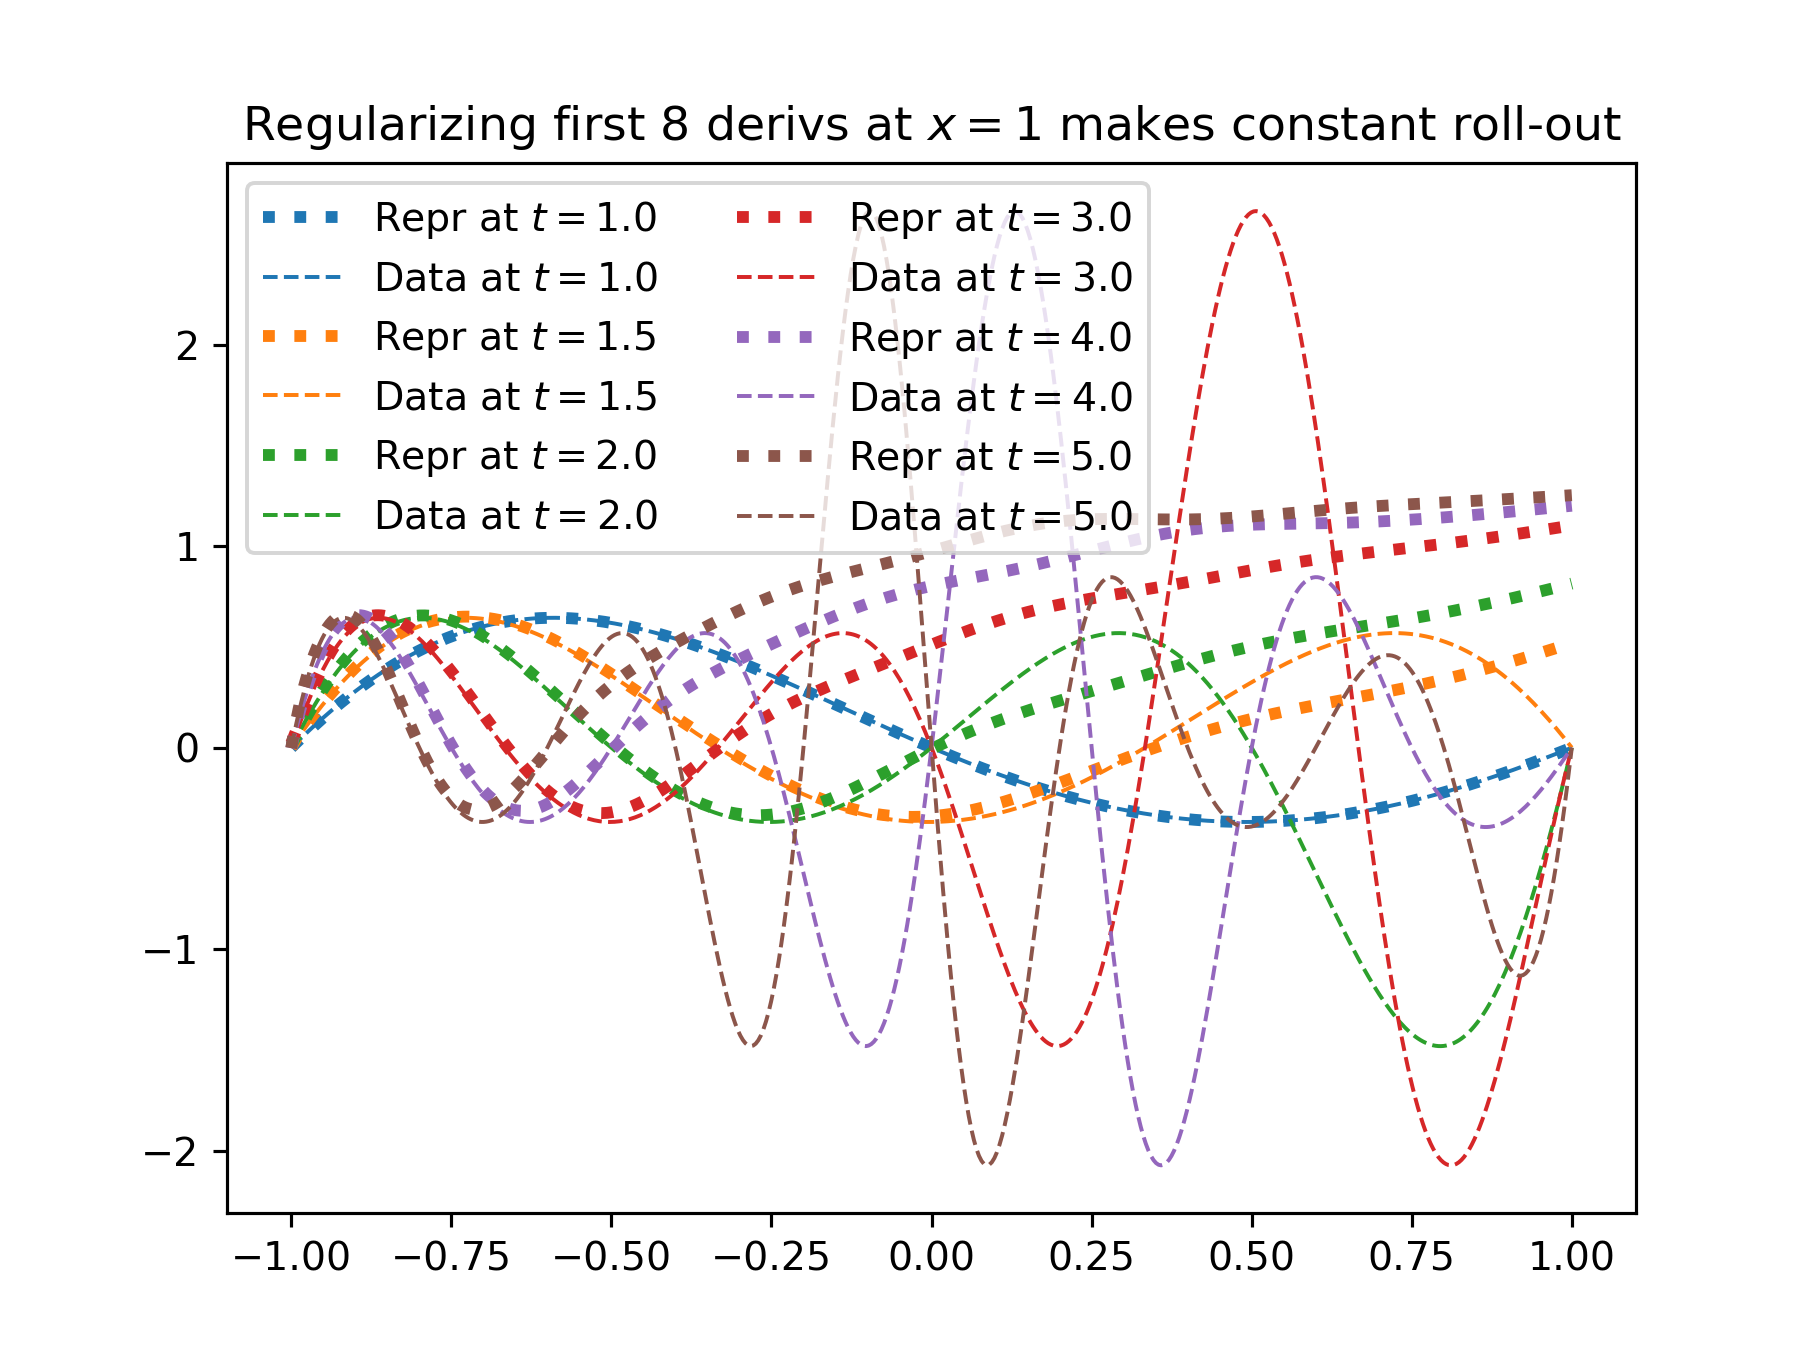

In [20]:
n = 20
lambda_ = 0.5
A = my_hippo_matrix(n)
f = Polynomial([-0.5, -3, 2])
def f(t):
    t = 2 * t
    return np.sin(np.pi * t) * np.exp(-np.sin(t))

K = 8
B = np.array([[leg_basis(j).deriv(i + 1)(1) for j in range(n)] for i in range(K)])
lhs = np.concatenate((np.identity(n), B), axis=0)

c = proj_leg(lambda x: f((x + 1) / 2), n)

x = np.linspace(-1, 1, 500)
poly_c = Legendre(c)

for dt in [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]:
    t0 = 1.0
    #c_later = solve_ivp(lambda t, c_: 1/t * A @ c_, (t0, t0 + dt), c).y[:, -1]
    def step(t, c_):
        return np.linalg.lstsq(lhs, np.concatenate((1/t * A @ c_, -lambda_ * B @ c_)), rcond=None)[0]
    sol = solve_ivp(step, (t0, t0 + dt), c)
    c_later = sol.y[:, -1]
    t = t0 + dt
    poly_later = Legendre(c_later)
    line, = pp.plot(x, poly_later(x), label=rf"Repr at $t={t}$", ls=":", lw=3)
    pp.plot(x, f(t * (x + 1) / 2), label=rf"Data at $t={t}$", ls="--", lw=1, c=line.get_color())

pp.legend(ncols=2)
pp.title(rf"Regularizing first {K} derivs at $x=1$ makes constant roll-out")

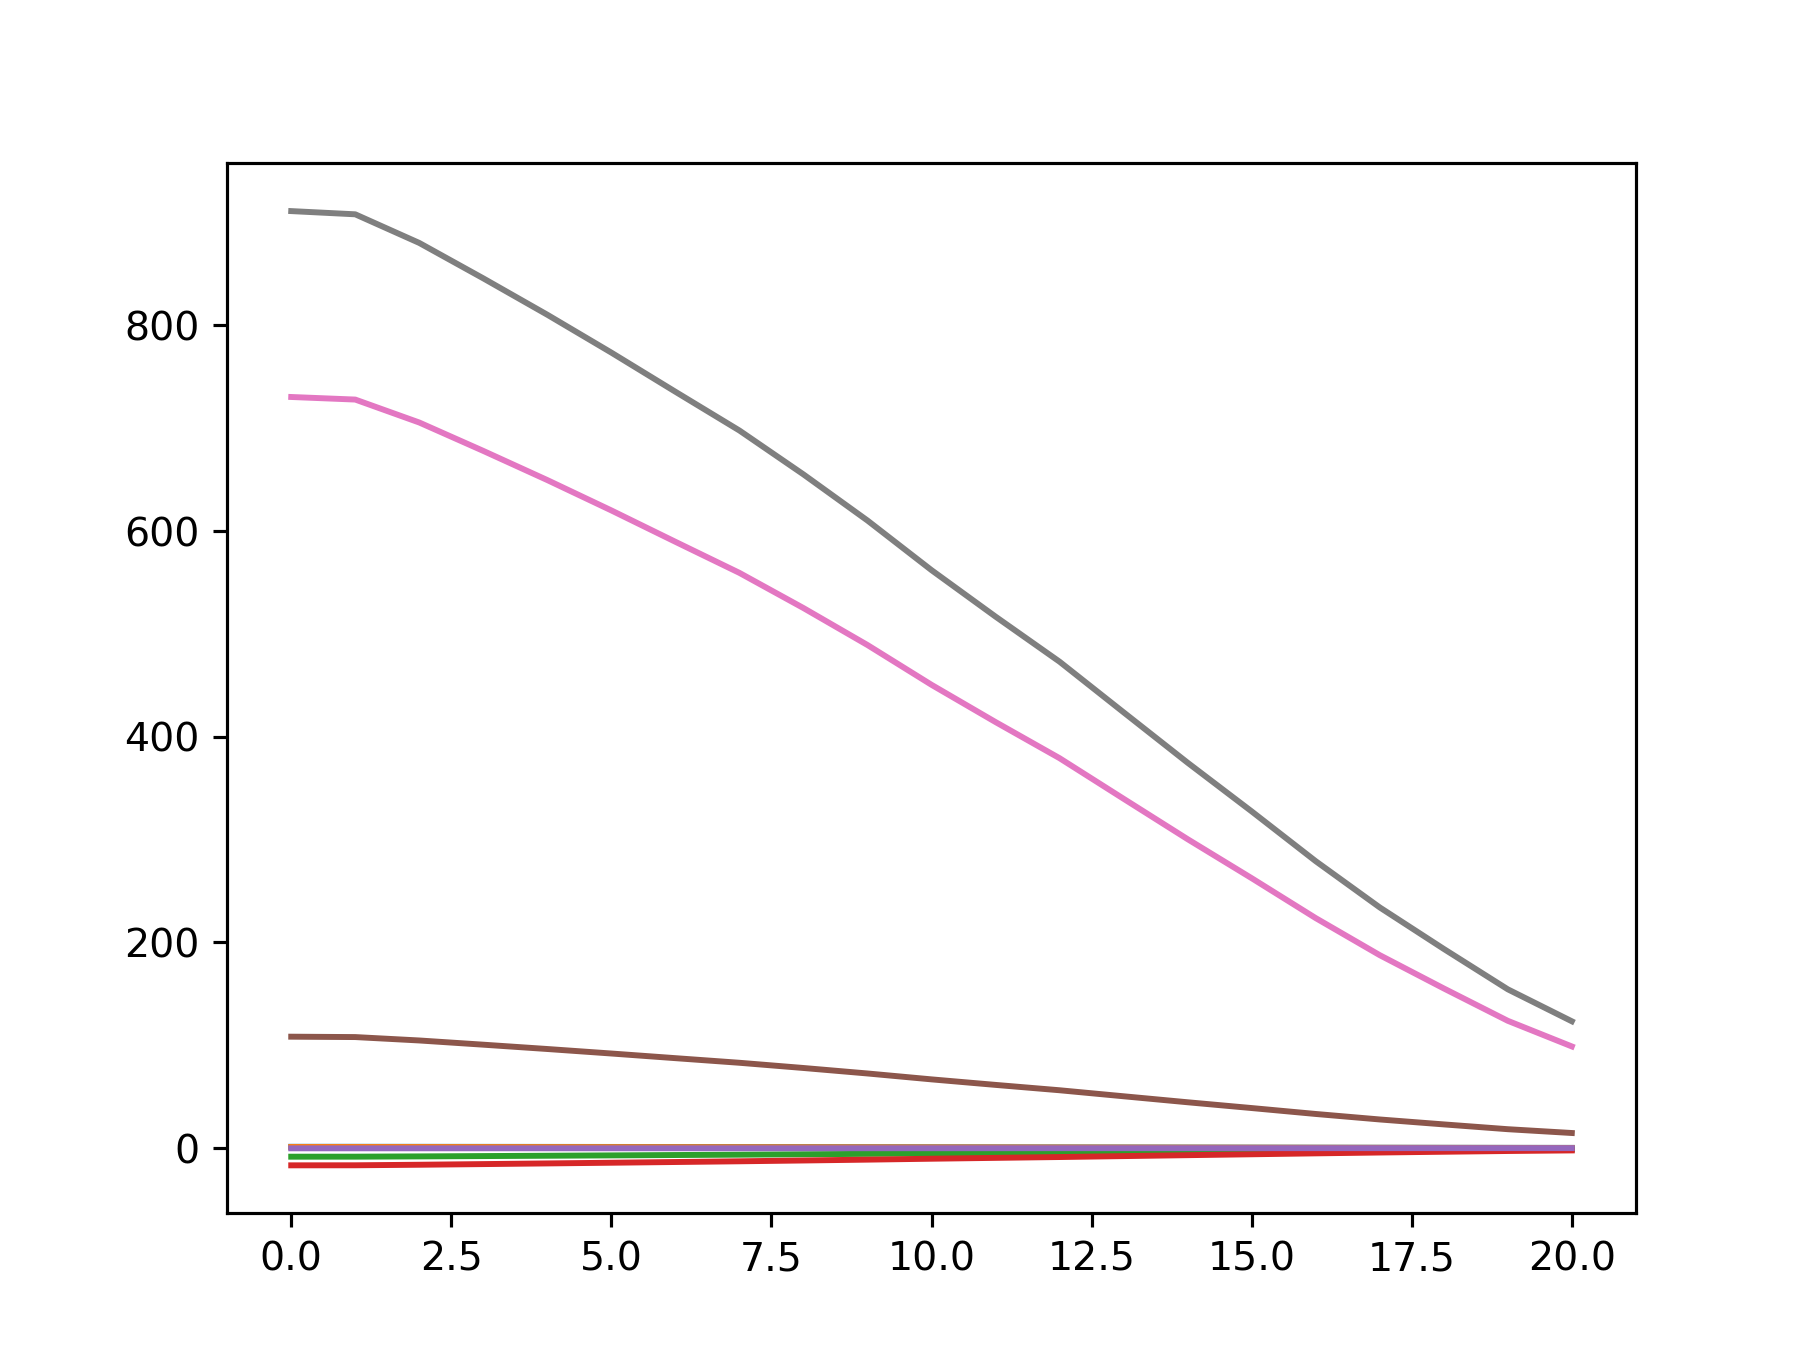

In [23]:
pp.plot((B @ sol.y).T)